In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import preprocessing
import umap
from matplotlib.backends.backend_pdf import PdfPages
import scipy as sp
from sklearn import preprocessing

warnings.filterwarnings("ignore")
import math
plt.rcParams["font.size"] = 10
from tsfresh import extract_features
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests


In [329]:

########## Load each data frame into dictionary - Permian ##########
file_names = ! ls permian_despiked_120523
# file_names = ! ls Permian
dict_dfs = {}
for file_name in file_names:
    df=pd.read_csv(f'permian_despiked_120523/{file_name}')
    # df=pd.read_csv(f'Permian/{file_name}')
    # remove_max=df[df['DEPTH(ft)']<=30].index.max()
    # array =np.empty((remove_max+1))
    # array[:] = np.nan
    # new_gamma = list(array) + list(df['Gamma(gapi)']) 
    # new_gamma= new_gamma[:-remove_max-1]
    # df['Gamma(gapi)_unlagged30'] = new_gamma
    dict_dfs[file_name]=df
    
# these are the cols of interest
consistent_col_names =['DEPTH(ft)',
 'ROP(ft / min)',
 'WOB(klbs)',
 'TPO(gal / min)',
 'RPM(rpm)',
 'SPP(psi)',
 'INC(deg)',
 'Gamma(gapi)',
 'DIFP(psi)']

df=dict_dfs['OXY_Gorilla204H_MDS.csv']
df=df[consistent_col_names].dropna() 

In [330]:
df_horz=df[df['INC(deg)']>80]

In [369]:
cols=['Gamma(gapi)',
 'WOB(klbs)',
 'TPO(gal / min)',
 'RPM(rpm)',
 'SPP(psi)',
 'INC(deg)',
 'DIFP(psi)']
gamma_corrs=[]
for file_name in file_names:
    df=dict_dfs[file_name]
    df=df[consistent_col_names].dropna() 
    c=df.iloc[:,1:].corr()['ROP(ft / min)']
    gamma_corrs.append(c[~c.index.isin(['ROP(ft / min)'])])
corr=pd.concat(gamma_corrs,axis=1)
corr.columns=pd.Series(file_names).str.replace('_MDS.csv','').str.replace('_',' ')

Text(0.0, 1.03, 'ROP(ft / min) correlations with MWD\nwithin Permian wells')

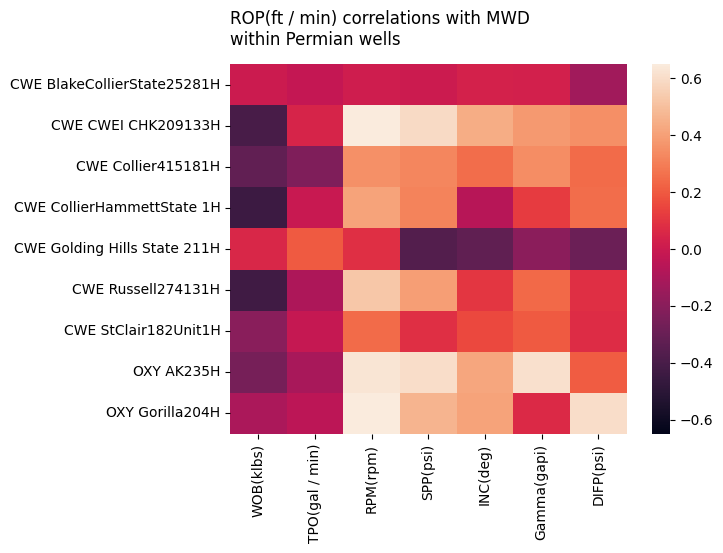

In [370]:
corr
sns.heatmap(data=corr.T,vmin=-.65, vmax=.65)
plt.title('ROP(ft / min) correlations with MWD\nwithin Permian wells',loc='left',y=1.03)

In [174]:


# get horz and vertical drilling separately
df_horz=df[df['INC(deg)']>80]
df_vert=df[df['INC(deg)']<=80]
# create ids to represent different windows -50ft
def add_ids(df):
    ids=[]
    window=60 #equivalent to 30ft
    id=0
    for i in range(1,len(df)+1):
        if (i/window).is_integer():
            id=i/window
            ids.append(id)
        else: 
            ids.append(id)
    df['id']=ids
    small_window=pd.Series(ids).value_counts()[pd.Series(ids).value_counts()<99].index[0]
    df= df[df['id']!=small_window] #remove small window
    df['id']=df['id'].astype(int)
    return df
df_horz=add_ids(df_horz)
df_vert=add_ids(df_vert)

# TODO consider nan handling
# df_features = extract_features(df_horz.dropna(), column_id="id", column_sort="DEPTH(ft)")


In [290]:
## approximate mechanical specific energy without torque  Osarogiagbon 2020 
df_horz=df[df['INC(deg)']>80]
df_horz['TOR(ft_lb)']=np.where(df_horz['TOR(ft_lb)']==0,np.nan,df_horz['TOR(ft_lb)'])
# df_horz=df_horz.dropna()
df_horz['MSEapprox']=((df_horz['WOB(klbs)']*1000)/(df_horz['BIT(in)']**2)) + (120*math.pi*df_horz['RPM(rpm)']*(1/df_horz['TOR(ft_lb)']))/((df_horz['BIT(in)']**2)*(df_horz['ROP(ft / min)']*60))
df_horz['MSEapprox1'] = df_horz['MSEapprox'] + ((df_horz['DIFP(psi)']*df_horz["TPO(gal / min)"])/((df_horz['BIT(in)']**2)*(df_horz['ROP(ft / min)']*60)))

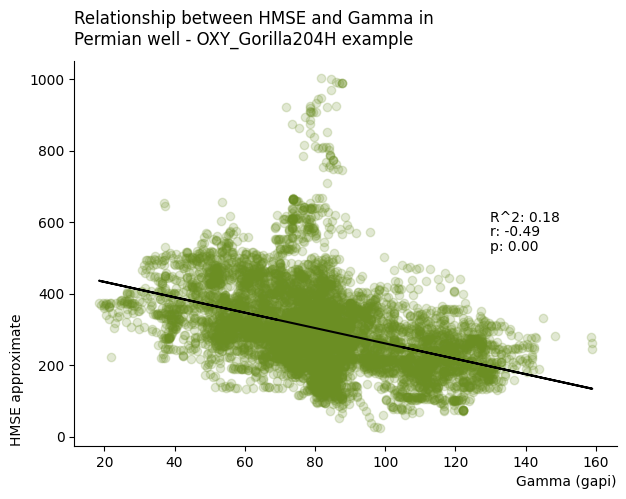

In [325]:
fig, ax=plt.subplots(figsize=(7,5))
df_horz=df_horz.dropna()
x=df_horz['Gamma(gapi)']
y=df_horz['MSEapprox1']
m, b, r_value, p_value, std_err = sp.stats.linregress(x, y)
ax.scatter(x,y, color='olivedrab',label='original',alpha=.2)
ax.plot(x, m*x + b,color='k',linestyle='-')
spearman=sp.stats.spearmanr(df_horz['Gamma(gapi)'],df_horz['MSEapprox1'])
ax.annotate('r: ' + str("{:.2f}".format(spearman[0])), xy=(130,560))
ax.annotate('p: ' + str("{:.2f}".format(spearman[1])), xy=(130,520))
ax.annotate('R^2: ' + str("{:.2f}".format(r_value**2)), xy=(130,600))
ax.set_xlabel('Gamma (gapi)',loc='right')
ax.set_ylabel('HMSE approximate',loc='bottom')
ax.set_title('Relationship between HMSE and Gamma in\nPermian well - OXY_Gorilla204H example',loc='left',y=1.02)
ax.spines[['right', 'top']].set_visible(False)



In [324]:
spearman[0]

-0.4909756234364889

In [296]:
for name in ['ROP(ft / min)','WOB(klbs)','TPO(gal / min)','RPM(rpm)','SPP(psi)','INC(deg)','DIFP(psi)','TOR(ft_lb)']:
    df2=df_horz[[name,'Gamma(gapi)']].dropna()
    y=df2[name]
    x=df2['Gamma(gapi)']
    print(sp.stats.
          (x,y),name)

SignificanceResult(statistic=0.10159308656163045, pvalue=5.1712687690541985e-19) ROP(ft / min)
SignificanceResult(statistic=-0.4712549305095573, pvalue=0.0) WOB(klbs)
SignificanceResult(statistic=0.03633118161405929, pvalue=0.0014797485410274023) TPO(gal / min)
SignificanceResult(statistic=-0.027002870585431354, pvalue=0.018169774285183855) RPM(rpm)
SignificanceResult(statistic=-0.09980891718981787, pvalue=2.109308601940606e-18) SPP(psi)
SignificanceResult(statistic=-0.06633070050325303, pvalue=6.330898390464762e-09) INC(deg)
SignificanceResult(statistic=-0.30228051590490346, pvalue=2.010268604170392e-161) DIFP(psi)
SignificanceResult(statistic=0.2504791022088872, pvalue=8.427238752568341e-110) TOR(ft_lb)


In [303]:
spearman=sp.stats.spearmanr(df_horz['Gamma(gapi)'],df_horz['MSEapprox1'])
spearman[0]

-0.4909756234364889

In [132]:
df_horz.columns

Index(['DEPTH(ft)', 'AZM(deg)', 'BIT(in)', 'DIFP(psi)', 'DLG(deg/100ft)',
       'EW(ft)', 'Gamma(gapi)', 'INC(deg)', 'LAGTIME(min)', 'NS(ft)',
       'ROP(ft / min)', 'RPM(rpm)', 'SLIDE(units)', 'SPP(psi)', 'TOR(ft_lb)',
       'TPO(gal / min)', 'TVD(ft)', 'WOB(klbs)', 'MSE1(ksi)', 'MSE2(ksi)',
       'MSE(ksi)', 'MSEapprox'],
      dtype='object')

(11600.0, 10500.0)

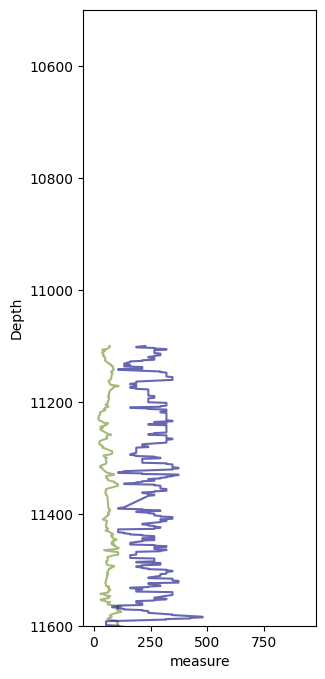

In [200]:
fig, ax=plt.subplots(figsize=(3,8))

ax.plot(df_horz['Gamma(gapi)'],df_horz['DEPTH(ft)'], color='olivedrab',label='original',alpha=.6)
ax.plot(df_horz['MSEapprox1'],df_horz['DEPTH(ft)'], color='navy',label='original',alpha=.6)
ax.set_xlabel('measure')
ax.set_ylabel('Depth')
ax.set_ylim(11600,10500)

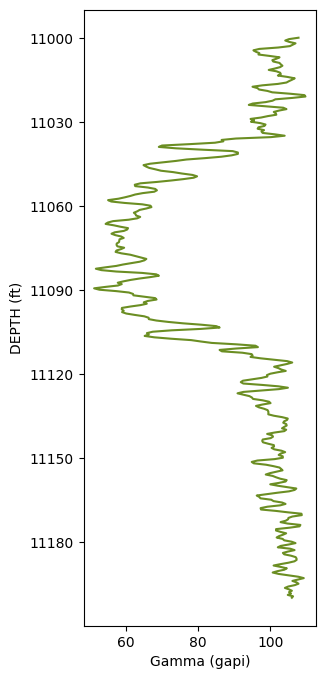

In [10]:

fig, ax=plt.subplots(figsize=(3,8))
plot_df=df_horz[['Gamma(gapi)','DEPTH(ft)']]
plot_df=plot_df[(plot_df['DEPTH(ft)']>=11000)&(plot_df['DEPTH(ft)']<=11200)]
ax.plot(plot_df['Gamma(gapi)'],plot_df['DEPTH(ft)'], color='olivedrab',label='original')
ax.set_xlabel('Gamma (gapi)')
ax.set_ylabel('DEPTH (ft)')
x=plot_df['DEPTH(ft)']
plt.yticks(np.arange(min(x), max(x)+1, 30.0))

# ax.set_title('')
ax.invert_yaxis()

## extract features at a window

In [13]:
fc_settings = {'mean': None}
df_horz['DEPTH(ft)_time']=df['DEPTH(ft)']

In [14]:
df_features = extract_features(df_horz, column_id="id", column_sort="DEPTH(ft)_time",default_fc_parameters=fc_settings)
df_features.columns


Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 10/10 [00:00<00:00, 11.32it/s]


Index(['DEPTH(ft)__mean', 'ROP(ft / min)__mean', 'WOB(klbs)__mean',
       'TPO(gal / min)__mean', 'RPM(rpm)__mean', 'SPP(psi)__mean',
       'INC(deg)__mean', 'Gamma(gapi)__mean', 'DIFP(psi)__mean'],
      dtype='object')

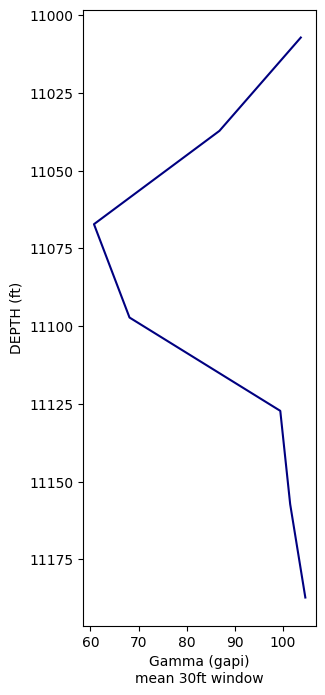

In [18]:
fig, ax=plt.subplots(figsize=(3,8))
plot_df=df_features[['Gamma(gapi)__mean','DEPTH(ft)__mean']]
plot_df=plot_df[(plot_df['DEPTH(ft)__mean']>=11000)&(plot_df['DEPTH(ft)__mean']<=11200)]
ax.plot(plot_df['Gamma(gapi)__mean'],plot_df['DEPTH(ft)__mean'], color='navy',label='original')
ax.set_xlabel('Gamma (gapi)\nmean 30ft window')
ax.set_ylabel('DEPTH (ft)')
ax.invert_yaxis()


In [104]:
# # pd.Series(df_features.columns[df_features.columns.str.contains('ROP')].str.replace('ROP(ft / min)__','')).to_csv('features.csv')
cols=list(df_features.columns[df_features.columns.str.contains('ROP')])
# cols

## Assess granger causality on raw features to see if they predict gamma - 

In [61]:
df_horz

,DEPTH(ft),ROP(ft / min),WOB(klbs),TPO(gal / min),RPM(rpm),SPP(psi),INC(deg),Gamma(gapi),DIFP(psi),BIT(in),Gamma(gapi)_unlagged30,id
21146,10573.0,0.183333,13.700000,246.000000,0.100000,2188.97,80.050000,84.3804,238.070000,6.13,102.4234,0
21147,10573.5,0.238333,14.100000,246.000000,0.100000,2227.59,80.101562,75.5345,276.590000,6.13,106.5349,0
21148,10574.0,0.266667,13.100000,246.000000,0.100000,2243.29,80.153125,72.2824,292.220000,6.13,109.7973,0
21149,10574.5,0.288333,12.500000,246.000000,0.100000,2225.67,80.204688,71.9504,274.720000,6.13,113.7333,0
21150,10575.0,0.316111,12.055556,245.888889,3.977778,2232.89,80.256250,72.2764,270.604444,6.13,117.1055,0
...,...,...,...,...,...,...,...,...,...,...,...,...
29790,14895.0,0.340000,24.700000,221.000000,4.000000,3030.07,89.865263,75.6183,265.640000,6.13,75.6183,144
29791,14895.5,0.295000,11.200000,221.000000,58.100000,3165.30,89.843684,75.6183,400.680000,6.13,75.6183,144
29792,14896.0,0.408333,11.500000,221.000000,59.100000,3110.84,89.822105,75.6183,346.250000,6.13,75.6183,144
29793,14896.5,0.886667,9.900000,221.000000,58.900000,3197.25,89.800526,75.6183,432.630000,6.13,75.6183,144


In [69]:
features = df_horz.columns[1:-1]
col=features[1]
result = adfuller(df[col])
print(col)
print(f'Test Statistics: {result[0]}')
print(f'p-value: {result[1]}')
print(f'critical_values: {result[4]}')
if result[1] > 0.05:
    print("Series is not stationary")
else:
    print("Series is stationary")

WOB(klbs)
Test Statistics: -11.082603284570562
p-value: 4.2740602017679e-20
critical_values: {'1%': -3.4310877841541583, '5%': -2.861866052116409, '10%': -2.5669435525409803}
Series is stationary


In [70]:
gc = grangercausalitytests(df_horz[['Gamma(gapi)', col]], maxlag=50,verbose=False)


In [71]:
lag_pvalues={}
for k,v in gc.items():
    if k>=30:
        lag_pvalues[k]=v[0]['params_ftest'][1]
lag_pvalues

{30: 0.8889434930977717,
 31: 0.7957190610037227,
 32: 0.7965257645013659,
 33: 0.7909090955013794,
 34: 0.753822083873425,
 35: 0.7856110199998049,
 36: 0.8173394142692672,
 37: 0.8471900045760425,
 38: 0.8481231948561001,
 39: 0.8556160803828587,
 40: 0.7337997136876182,
 41: 0.7446538593197431,
 42: 0.7617976894032865,
 43: 0.7118565863634836,
 44: 0.6458006983542526,
 45: 0.5643707465694061,
 46: 0.5653777352254485,
 47: 0.586556759937316,
 48: 0.5509686283103107,
 49: 0.39443141854668745,
 50: 0.42987999000695043}